In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner 
# import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader

file = '../dataset/omega.mon.mean.nc'
dataset = nc.Dataset(file)
# print(dataset.variables.keys())


/home/lk/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/lk/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/lk/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
phase1 = np.squeeze(dataset['omega'][384:624,5:6,:,:])
phase2 = np.squeeze(dataset['omega'][624:900,5:6,:,:])

In [3]:
mean_phase1 = np.zeros((20, 73, 144), dtype=float, order='C')
zero_month = np.zeros((73, 144), dtype=float, order='C')
for month in range(0, 624-384, 12):
    for i in range(12):
        zero_month += phase1[month+i]
    index = int(month/12)
    mean_phase1[index] = zero_month/12
    
mean_phase2 = np.zeros((23, 73, 144), dtype=float, order='C')
for month in range(0, 900-624, 12):
    for i in range(12):
        zero_month += phase2[month+i]
    index = int(month/12)
    mean_phase2[index] = zero_month/12
    


In [4]:
zero_phase1 = np.zeros(phase1.shape, dtype=float, order='C')
zero_month = np.zeros((73, 144), dtype=float, order='C')
mean_phase1 = zero_month
mean_phase2 = zero_month
for month in range(624-384):
    zero_month += phase1[month]
mean_phase1 = zero_month/(624-384)
    
zero_phase2 = np.zeros(phase2.shape, dtype=float, order='C')
for month in range(900-624):
    zero_month += phase2[month]
mean_phase2 = zero_month/(900-624)

diff = mean_phase2-mean_phase1


In [5]:
print(diff.min(), diff.max())

-0.0684516173430155 0.07959540250679088


In [54]:
dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    description: Data from NCEP initialized reanalysis (4x/day).  These are interpolated to pressure surfaces from model (sigma) surfaces
    platform: Model
    Conventions: COARDS
    NCO: 20121012
    history: Thu May  4 18:09:59 2000: ncrcat -d time,0,622 /Datasets/ncep.reanalysis.derived/pressure/omega.mon.mean.nc ./pressure/omega.mon.mean.nc
Mon Jul  5 22:14:11 1999: ncrcat omega.mon.mean.nc /Datasets/ncep.reanalysis.derived/pressure/omega.mon.mean.nc /dm/dmwork/nmc.rean.ingest/combinedMMs/omega.mon.mean.nc
created by Cathy Smith 12/5/95
(netCDF2.3)
Converted to chunked, deflated non-packed NetCDF4 2014/09
    title: monthly mean omega from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
    References: http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis.derived.html
    dimensions(sizes): level(12), lat(73), lon(144), time(914)
    variables(dimensions): float32 leve

In [6]:
longitude = dataset['lon'][:]
latitude = dataset['lat'][:]

73


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


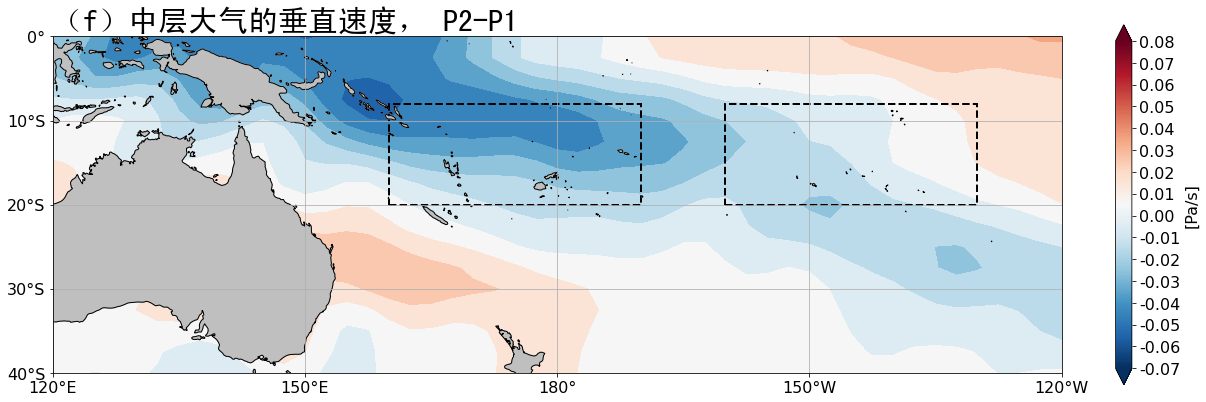

In [7]:
from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 

from matplotlib import rcParams
from matplotlib import patches
import matplotlib

matplotlib.font_manager.fontManager.addfont('../qixiang/font/SimHei.ttf') 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False#用来正常显示负号

# 设置字体
config = {
    "font.family": 'Times New Roman',
    "font.size": 16,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)

MAX = 0.08
MIN = -0.07
INTER = 0.01

# 设置经纬度
# lon = longitude[:].data
lon = np.append(longitude[:].data, [360.0])
lat = latitude[:].data

print(len(lat))
# 调整经纬度 向东偏移180
# lon_pacific = lon[:] + 180
# a, b = np.hsplit(diff, [179])
# diff_pacific_contre = np.concatenate([b, a], axis=1) # 转换为以太平洋为中心的数据
diff_2d = diff
new_diff=[]
for i in range(diff_2d.shape[0]):
    tmp = np.append(diff_2d[i], diff_2d[i][0])
    new_diff.append(tmp.tolist())
new_diff = np.array(new_diff)

fig = plt.figure(figsize=(15,5))

proj = ccrs.PlateCarree(central_longitude=180)
# proj = ccrs.PlateCarree()
leftlon, rightlon, lowerlat, upperlat = (120,240, -40, 0)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0, 1, 1],projection = proj)

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks([ -150, -120, 120, 150, 180], crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-40,1,10), crs=ccrs.PlateCarree())
fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('（f）中层大气的垂直速度， P2-P1',
                  loc='left',fontproperties='SimHei', 
                  fontsize =30, fontweight='bold')

cont = fig_ax1.contourf(lon, lat, new_diff, 
                 levels=np.arange(MIN, MAX, INTER), # 颜色分片
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)

black_quarter_b1 = patches.Rectangle((160,-20),30,12,linestyle = 'dashed', 
                                  lw=2, edgecolor='black', facecolor='none',transform=ccrs.PlateCarree())
black_quarter_b2 = patches.Rectangle((200,-20),30,12,linestyle = 'dashed', 
                                  lw=2, edgecolor='black', facecolor='none',transform=ccrs.PlateCarree())
fig_ax1.add_patch(black_quarter_b1)
fig_ax1.add_patch(black_quarter_b2)

norm = colors.Normalize(vmin=MIN, vmax=MAX)    #确定colormap的最大最小值

cmap=plt.cm.RdBu_r  #引用NCL的colormap

# newcolors=cmap(np.linspace(-14,15,9))#分片操作，生成0到1的12个数据间隔的数组   

# newcmap=ListedColormap(newcolors[::])  #重构为新的colormap

fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,
                                       cmap=plt.cm.RdBu_r
#                                        cmap = newcmap
                                      ),
#                  cax = fig.add_axes([0,0,0.05,0.9]),
                 orientation='vertical',label='[Pa/s]',
                 ticks=np.arange(MIN, MAX, INTER).tolist(), # colorbar分片                                                 
                 extend='both',
                fraction=0.0158) 

# plt.colorbar(cont,fraction=0.012)

plt.savefig("omega_20240312.png",dpi=300,bbox_inches='tight')
plt.show()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


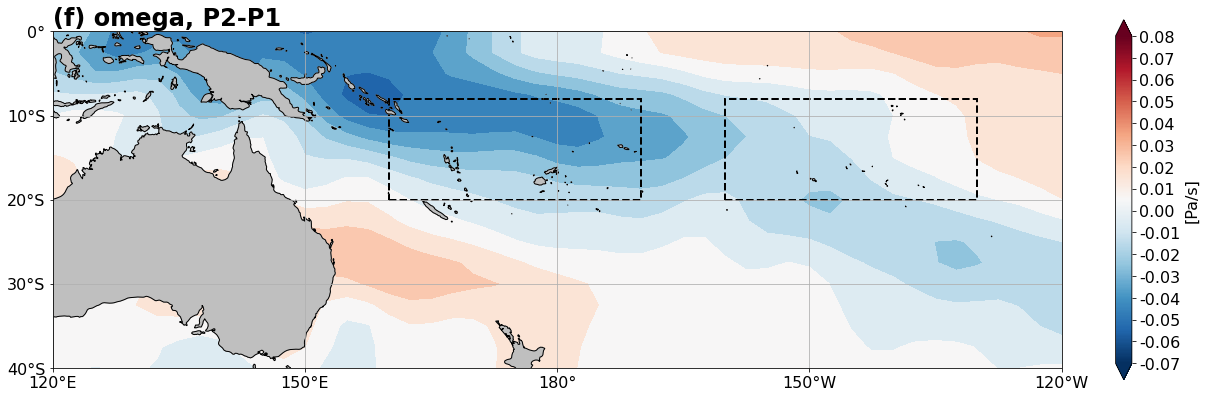

In [8]:
from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 

from matplotlib import rcParams
from matplotlib import patches


# 设置字体
config = {
    "font.family": 'Times New Roman',
    "font.size": 16,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)

MAX = 0.08
MIN = -0.07
INTER = 0.01

# 设置经纬度
# lon = longitude[:].data
lon = np.append(longitude[:].data, [360.0])
lat = latitude[:].data

# 调整经纬度 向东偏移180
# lon_pacific = lon[:] + 180
# a, b = np.hsplit(diff, [179])
# diff_pacific_contre = np.concatenate([b, a], axis=1) # 转换为以太平洋为中心的数据
diff_2d = diff
new_diff=[]
for i in range(diff_2d.shape[0]):
    tmp = np.append(diff_2d[i], diff_2d[i][0])
    new_diff.append(tmp.tolist())
new_diff = np.array(new_diff)

fig = plt.figure(figsize=(15,5))

proj = ccrs.PlateCarree(central_longitude=180)
# proj = ccrs.PlateCarree()
leftlon, rightlon, lowerlat, upperlat = (120,240, -40, 0)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
fig_ax1 = fig.add_axes([0, 0, 1, 1],projection = proj)

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks([ -150, -120, 120, 150, 180], crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-40,1,10), crs=ccrs.PlateCarree())
fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(f) omega, P2-P1',
                  loc='left',
                  fontsize =24, fontweight='bold')

cont = fig_ax1.contourf(lon, lat, new_diff, 
                 levels=np.arange(MIN, MAX, INTER), # 颜色分片
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)

black_quarter_b1 = patches.Rectangle((160,-20),30,12,linestyle = 'dashed', 
                                  lw=2, edgecolor='black', facecolor='none',transform=ccrs.PlateCarree())
black_quarter_b2 = patches.Rectangle((200,-20),30,12,linestyle = 'dashed', 
                                  lw=2, edgecolor='black', facecolor='none',transform=ccrs.PlateCarree())
fig_ax1.add_patch(black_quarter_b1)
fig_ax1.add_patch(black_quarter_b2)

norm = colors.Normalize(vmin=MIN, vmax=MAX)    #确定colormap的最大最小值

cmap=plt.cm.RdBu_r  #引用NCL的colormap

# newcolors=cmap(np.linspace(-14,15,9))#分片操作，生成0到1的12个数据间隔的数组   

# newcmap=ListedColormap(newcolors[::])  #重构为新的colormap

fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,
                                       cmap=plt.cm.RdBu_r
#                                        cmap = newcmap
                                      ),
#                  cax = fig.add_axes([0,0,0.05,0.9]),
                 orientation='vertical',label='[Pa/s]',
                 ticks=np.arange(MIN, MAX, INTER).tolist(), # colorbar分片                                                 
                 extend='both',
                fraction=0.0158) 

# plt.colorbar(cont,fraction=0.012)

plt.savefig("omega_20240312_cn.png",dpi=300,bbox_inches='tight')
plt.show()